# Go faster: numba

*Davide Gerosa (Milano-Bicocca)*

**Sources**: The data frog: https://thedatafrog.com/en/articles/make-python-fast-numba 

The usual criticism to python is that it's slow. The underlying reason is that python is an interpreted language and not a compiled language (but that's also why python it's nice and simple!).

Numpy largely solves the speed problem in most cases, but not everything can be written in a numpy-compatible form (or even if it can, you might need to rewrite substantial chunks of code). 

## Extensions 

There are a few ways to make python faster, which are called _extensions_. Typically, these boils down to either
- Write some core functions in compiled language like C or Fortran and interface it with python. This is also useful to recycle some legacy code written by the supervisor of your supervisor that doesn't know python.
- Use a library that converts python into compiled code (with some restrictions)

Some libraries:

* **C**
  * [C-API](https://docs.python.org/3/c-api/index.html) : the
    standard python interpreter (cpython) is written in C, so it is
    natural that we can write C code to interact with our python code.
    This is the python C-API.  Since numpy is also written in C, we
    can work with numpy arrays in C code as well.
    This will give us the performance of C compiled code, but the
    downside is that we lose a lot of what makes python great.  We
    need to pass data into C as pointers and cast them into types that
    represent the arrays we use.  This means writing a lot of
    boilerplate code just to deal with some simple operations. These days, there are better methods for most applications.
  * [ctypes](https://docs.python.org/3/library/ctypes.html) : this
    is a module that allows you to call functions in shared libraries.
    This is part of standard python. With ctypes, you don't need to modify your C code -- you just need to
    define an interface to the C function in python.  However, the calling
    mechanism can be slow. There is support for numpy through numpy.ctypeslib.

* **Fortran**
  * [f2py](https://numpy.org/doc/stable/f2py/) : this is part of
    numpy.  It allows for easy calling of Fortran from python.
    You essentially just need to add some comments to your Fortran
    code to allow f2py to build an interface.  f2py understands the
    different orderings of indices between C and Fortran arrays.

* **python**
  * [Cython](https://cython.org/) : this is a superset of python that can convert python into
    compiled C code. The advantage here is that the code looks like python, with some
    declarations of the variable types with `cdef`.  Performance can be
    really great when you need to explicitly write out loops over
    numpy array indices.
  * [Numba](https://numba.pydata.org/) : this is a just-in-time
    compiler.  It just requires a simple decorator and then it will
    compile a python function the first time it is encountered.

* **GPU**: The modern (think deep learning) way of going faster is actually changing hardware and using GPUs instead of CPUs. That could probably fill an entire class, but [this](https://thedatafrog.com/en/articles/boost-python-gpu/) is a nice tutorial. There's even [some hardware](https://cloud.google.com/tpu/docs/intro-to-tpu) that is specifically built for AI (Google builds it to run TensorFlow).
    


Just-in-time compiliation seems to be the cool thing to do, so here we'll look at Numba. But before that... 

## Python decorators

With numba, the compilation of a python function is triggered by a decorator.

A python decorator is a function that takes another function as input, modifies it, and returns the modified function to the user. I realize that this sentence sounds tricky, but it's not. 

Remember that in python everything is an object. Functions are objects, and classes are objects too. For instance, let's take this simple function:

In [1]:
def hello():
  print('Hello world')

`hello` is a function object, so we can pass it to another function like this one:

In [2]:
def make_sure(func):
  def wrapper():
    while 1:
      res = input('are you sure you want to greet the world? [y/n]')
      if res=='n':
        return
      elif res=='y':
        func()
        return
  return wrapper

This is a decorator! `make_sure` takes an input function and returns a new function that wraps the input function.

Below, we decorate the function `hello`, and `whello` is the decorated function:

In [3]:
whello = make_sure(hello)
whello()


are you sure you want to greet the world? [y/n]y
Hello world


Of course, we can use the make_sure decorator on any function that has the same signature as `func` (can work without arguments, and no need to retrieve the output).

We know enough about decorators to use numba. Still, just one word about the syntax. We can also decorate a function in this way:

In [4]:
@make_sure
def hello():
  print('Hello world')

hello()

are you sure you want to greet the world? [y/n]
are you sure you want to greet the world? [y/n]
are you sure you want to greet the world? [y/n]y
Hello world


There is really nothing mysterious about this, it's just a nice and easy syntax to decorate the function as soon as you write it.

## Just-in-time compilation with numba


Numba is able to compile python code into bytecode optimized for your machine, with the help the LLVM library. You don't really need to know what LLVM is to follow this tutorial, but here is a [nice introduction to LLVM](https://www.infoworld.com/article/3247799/what-is-llvm-the-power-behind-swift-rust-clang-and-more.html) in case you're interested.

Here is a function that can take a bit of time. This function takes a list of numbers, and returns the standard deviation of these numbers.

In [5]:
import math

def std(xs):
  # compute the mean
  mean = 0
  for x in xs:
    mean += x
  mean /= len(xs)
  # compute the variance
  ms = 0
  for x in xs:
     ms += (x-mean)**2
  variance = ms / len(xs)
  std = math.sqrt(variance)
  return std

As we can see in the code, we need to loop twice on the sample of numbers: first to compute the mean, and then to compute the variance, which is the square of the standard deviation.

Obviously, the more numbers in the sample, the more time the function will take to complete. Let's start with 10 million numbers, drawn from a Gaussian distribution of unit standard deviation:

In [14]:
import numpy as np
a = np.random.normal(0, 1, 10000000)

In [15]:
std(a)

1.0004672111725679

The function takes a second or so to compute the standard deviation of the sample.

Now, let's import the njit decorator from numba, and decorate our std function to create a new function:

In [16]:
from numba import njit
c_std = njit(std)

In [17]:
c_std(a)

1.0004672111725679

The performance improvement might not seem striking, but that's because the first time the function is called, numba will need to compile the function, which takes a bit of time.

But we can quantify the improvement using the timeit magic function, first for the interpreted version of the std function, and then for the compiled version:

In [18]:
%timeit std(a)

1.51 s ± 28.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit c_std(a)

17.2 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The compiled function is 100 times faster!

But obviously we did not have to go into such trouble to compute the standard deviation of our array. For that, we can simply use numpy:

In [20]:
a.std()

1.0004672111725286

In [21]:
%timeit a.std()

12 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this particular case numba and numpy are comparable, but we'll see numba is much more flexible.

## Calculation of pi

the number pi can be estimated with a very elegant Monte Carlo method.

Just consider a square of side L=2, centred on (0,0). In this square, we fit a circle of radius R=1, as shown in the figure below.

![](https://raw.githubusercontent.com/cbernet/maldives/master/numba/pi_mc.png)


The ratio of the circle area to the square area is

$$r = \frac{A_c}{A_s} = \frac{\pi R^2}{L^2} = \pi / 4$$

so

$$\pi = 4 r$$

So if we can estimate this ratio, we can estimate pi!

And to estimate this ratio, we will simply shoot a large number of points in the square, following a uniform probability distribution. The fraction of the points falling in the circle is an estimator of r.

Obviously, the more points, the more precise this estimator will be, and the more decimals of pi can be computed.

Let's implement this method, and use it with an increasing number of points to see how the precision improves.


In [22]:
import random

def pi(npoints):
  n_in_circle = 0
  for i in range(npoints):
    x = random.random()
    y = random.random()
    if (x**2+y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / npoints

In [23]:
npoints = [10, 100, 10000, int(10e6)]
for number in npoints:
  print(pi(number))


4.0
3.16
3.1356
3.1409976


As you can see, even with N=10 million points, the precision is not great. More specifically, the relative uncertainty on pi can be calculated as

$$\delta = 1/ \sqrt{N}$$

(If you don't know why go back to your stats textbook)

Here is how the uncertainty evolves with the number of points:

In [25]:
import math
# defining the uncertainty function
# with a lambda construct
uncertainty = lambda x: 1/math.sqrt(x)
for number in npoints:
  print('npoints', number, 'delta:', uncertainty(number))

npoints 10 delta: 0.31622776601683794
npoints 100 delta: 0.1
npoints 10000 delta: 0.01
npoints 10000000 delta: 0.00031622776601683794


Clearly, we'll need a lot of points. How fast is our code?

In [26]:
%timeit pi(10000000)

1.22 s ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A few seconds for 10 million points. This algorithm is O(N), so if we want to use 1 **billion** points, it will take us between 5 and 10 minutes . We don't have that much time, so let's use numba!

In [29]:
@njit
def fast_pi(npoints):
  n_in_circle = 0
  for i in range(npoints):
    x = random.random()
    y = random.random()
    if (x**2+y**2 < 1):
      n_in_circle += 1
  return 4*n_in_circle / npoints

In [30]:
fast_pi( int(1e9) )

3.14153064

This took <10 s, instead of 10 minutes!

## Finding the closest two points

Numpy features an efficient implementation for most array operations. 

My suggestion: **If numpy can do it, just go for it.** Once you've abandoned your C mindeset of using indexes for everything, numpy is just easier to write, easier to read, and the world is shining. 

But sometimes, you'll come up with an expensive algorithm that cannot easily be implemented with numpy. For instance, let's consider the following function, which takes an array of 2D points, and looks for the closest two points.

In [42]:
import sys
def closest(points):
  '''Find the two closest points in an array of points in 2D.
  Returns the two points, and the distance between them'''

  # we will search for the two points with a minimal
  # square distance.
  # we use the square distance instead of the distance
  # to avoid a square root calculation for each pair of
  # points

  mindist2 = 999999.
  mdp1, mdp2 = None, None
  for i in range(len(points)):
    p1 = points[i]
    x1, y1 = p1
    for j in range(i+1, len(points)):
      p2 = points[j]
      x2, y2 = p2
      dist2 = (x1-x2)**2 + (y1-y2)**2
      if dist2 < mindist2:
        # squared distance is improved,
        # keep it, as well as the two
        # corresponding points
        mindist2 = dist2
        mdp1,mdp2 = p1,p2
  return mdp1, mdp2, math.sqrt(mindist2)

You might be thinking that this algorithm is quite naive, and it's true! It was written like this on purpose.

You can see that there is a double loop in this algorithm. So if we have N points, we would have to test NxN pairs of points, so the computational complexity here is $O(N^2)$.

To improve the situation a bit, please note that the distance between point i and point j is the same as the distance between point j and point i!
So there is no need to check this combination twice. Also, the distance between point i and itself is zero, and should not be tested...That's why we started the inner loop at i+1. So the combinations that are tested are:

* (0,1), (0,2), ... (0, N)
* (1,2), (1,3), ... (1, N)
* ...

Another thing to note is that we're doing all we can to limit the amount of computing power needed for each pair. That's why it's minimizing the square distance instead of the distance itself, which saves us a call to math.sqrt for every pair of points.

Still, the algorithm remains $O(N^2)$.

Let's first run this algorithm on a small sample of 10 points, just to check that it works correctly.

In [43]:
points = np.random.uniform((-1,-1), (1,1), (10,2))
print(points)
closest(points)

[[ 0.36473207  0.987088  ]
 [-0.68937368 -0.85826209]
 [ 0.36812674  0.56381749]
 [-0.47289578 -0.82180449]
 [-0.23918686  0.42850499]
 [-0.90566129 -0.32527947]
 [-0.10320767  0.54486379]
 [-0.51233459 -0.5709418 ]
 [ 0.40029774 -0.14219457]
 [-0.03475359 -0.95287284]]


(array([-0.23918686,  0.42850499]),
 array([-0.10320767,  0.54486379]),
 0.1789684654011168)

Ok, this looks right, the two points indeed appear to be quite close. Let's see how fast is the calculation:

In [44]:
%timeit closest(points)

27 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Now, let's increase a bit the number of points in the sample. You will see that the calculation will be much slower.

In [45]:
points = np.random.uniform((-1,-1), (1,1), (2000,2))
closest(points)

(array([-0.44920338, -0.56511631]),
 array([-0.44898103, -0.56547034]),
 0.0004180596716534414)

In [46]:
%timeit closest(points)

996 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Since our algorithm is O(NxN), if we go from 10 to 2,000 points, the algorithm will be 200x200 = 40,000 times slower.

Now let's try and speed this up with numba's just in time compilation:

In [47]:
c_closest = njit(closest)
c_closest(points)

(array([-0.44920338, -0.56511631]),
 array([-0.44898103, -0.56547034]),
 0.0004180596716534414)

In [48]:
c_closest(points)

(array([-0.44920338, -0.56511631]),
 array([-0.44898103, -0.56547034]),
 0.0004180596716534414)

In [49]:
%timeit closest(points)

1.01 s ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit c_closest(points)

10.1 ms ± 891 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again, the compiled code is 100 times faster!

# Exercises

## Q1: The stock market

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Marov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [47]:
import random
import numpy as np

states = ["bull","bear","stagnant"]
N_DAYS = int(1e7)
probs = np.array([[0.9,0.975,1],[0.15,0.85,1],[0.25,0.5,1]])
#days_in[current_state] += 1
def markov_chain(probs, n_states=3, N = 10000):
    days_in = np.zeros(n_states)
    parziali = []
    parziali_x = []
    current_state = random.randint(0,n_states-1)
    for k in range(N):
        #print("current_state", current_state)
        prob_next = random.random()
        #print("prob next", prob_next)
        next_state = 0
        while prob_next > probs[current_state][next_state]:
            next_state += 1
        current_state = next_state
        days_in[current_state] += 1
        #print("current_state", current_state)
        if k % 10 == 0 and k != 0:
            parziali_x.append(k)
            parziali.append(days_in/k)
    return parziali_x, parziali, days_in

In [48]:
%timeit parziali_x, parziali, days_in = markov_chain(probs, N = N_DAYS)

The slowest run took 5.35 times longer than the fastest. This could mean that an intermediate result is being cached.
43.4 s ± 33.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
import numba

@numba.njit
def markov_chain(probs, n_states=3, N = 10000):
    days_in = np.zeros(n_states)
    parziali = []
    parziali_x = []
    current_state = random.randint(0,n_states-1)
    for k in range(N):
        #print("current_state", current_state)
        prob_next = random.random()
        #print("prob next", prob_next)
        next_state = 0
        while prob_next > probs[current_state][next_state]:
            next_state += 1
        current_state = next_state
        days_in[current_state] += 1
        #print("current_state", current_state)
        if k % 10 == 0 and k != 0:
            parziali_x.append(k)
            parziali.append(days_in/k)
    return parziali_x, parziali, days_in

In [50]:
%timeit parziali_x, parziali, days_in = markov_chain(probs, N = N_DAYS)

1.52 s ± 227 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


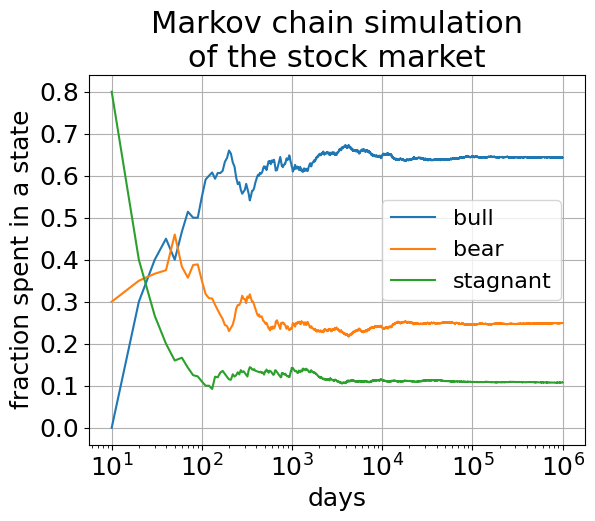

In [52]:
import matplotlib.pyplot as plt
plt.plot(parziali_x, parziali, label=states)
plt.legend(fontsize=16, loc=(0.59,0.39))
plt.xscale("log")
plt.title("Markov chain simulation\nof the stock market", fontsize=22)
plt.xlabel("days", fontsize=18)
plt.ylabel("fraction spent in a state", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid()
plt.show()

## Q2: Consistent plotting

(This is about dectorators, not numba)

Write a decorator for the plots of all your papers. For instance, you could use it to initialize a matplotlib figure with the options that you like the most and save it to pdf. This will ensure all plots have the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my [skywalker](https://github.com/dgerosa/skywalker) python module.  